Klasifikacija slika koriscenjem CCN arhitekture


*   Dataset :Cats vs. Dogs
*   Arhitektura: MobileNetV2
*   Pretprocesiranje: Random flip, shift
*   Optimizator: Adam



Povezivanje sa drive-om

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append("drive/My Drive/Colab Notebooks/datasets/")

Ucitavanje biblioteka

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import  preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import RandomFlip,RandomTranslation,RandomZoom,RandomRotation,BatchNormalization,ReLU,Rescaling
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import seaborn as sns

%matplotlib inline

np.random.seed(1)


Ucitavanje slika

In [ ]:
# Postavke
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_path = "drive/My Drive/Colab Notebooks/datasets/train/"
test_path = "drive/My Drive/Colab Notebooks/datasets/test/"


train_dataset = image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    seed=42
)

# Ispravno učitavanje validacionog skupa sa različitim seed-om
test_dataset = image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    seed=42
)

Found 3235 files belonging to 2 classes.
Found 692 files belonging to 2 classes.


Pronadjene su dve klase psi i macke

In [ ]:
class_names = train_dataset.class_names

In [ ]:
class_names

['cats', 'dogs']

Prikaz nekih slika iz seta podataka

In [ ]:
plt.figure(figsize=(20,20))
for images, labels in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

Output hidden; open in https://colab.research.google.com to view.

Data Augmentacija (RadnomFlip, shiht ) obavezno umesto shift mozemo da koristimo RandomTranslation da bi psotigli isti efekat

In [ ]:
def data_augmenter():
    data_augmenten = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomFlip("vertical"),    # Nasumično flipovanje vertikalno
        RandomTranslation(height_factor=0.2, width_factor=0.2),  # Nasumično pomeranje
        RandomRotation(0.5),  # Nasumično rotacija
        RandomZoom(0.5)  # Nasumično skaliranje
    ])
    return data_augmenten

In [ ]:
data_augmentation = data_augmenter()

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), include_top = False, weights = "imagenet")

Broj slojeva convulucione mreze

In [ ]:
len(base_model.layers)

154

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Kreiranje modela

In [ ]:
def CatsVsDogs(image_shape=(224,224), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top = False, weights = "imagenet") # Promenjeno na ImageNet težine
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=CatsVsDogs()

In [ ]:
len(model.layers)

16

In [ ]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,139,073 (11.97 MB)

 Trainable params: 879,425 (3.35 MB)

 Non-trainable params: 2,259,648 (8.62 MB)

Treniranje modela sa learning_rate = 0,001 i batch_size 32



In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]

)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - AUC: 0.5644 - accuracy: 0.5472 - loss: 0.7707 - val_AUC: 0.6523 - val_accuracy: 0.5029 - val_loss: 1.0655
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - AUC: 0.6259 - accuracy: 0.5952 - loss: 0.7117 - val_AUC: 0.5947 - val_accuracy: 0.5434 - val_loss: 0.6970
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - AUC: 0.5998 - accuracy: 0.5664 - loss: 0.7130 - val_AUC: 0.6607 - val_accuracy: 0.6026 - val_loss: 0.6610
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - AUC: 0.6645 - accuracy: 0.6146 - loss: 0.6664 - val_AUC: 0.6938 - val_accuracy: 0.6358 - val_loss: 0.6963
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - AUC: 0.6402 - accuracy: 0.6067 - loss: 0.6808 - val_AUC: 0.6978 - val_accuracy: 0.5882 - val_loss: 0.7914
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - AUC: 0.6391 - accuracy: 0.5967 - loss: 0.6952 - val_AUC: 0.7120 - val_accuracy: 0.6517 - val_loss: 0.6316
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

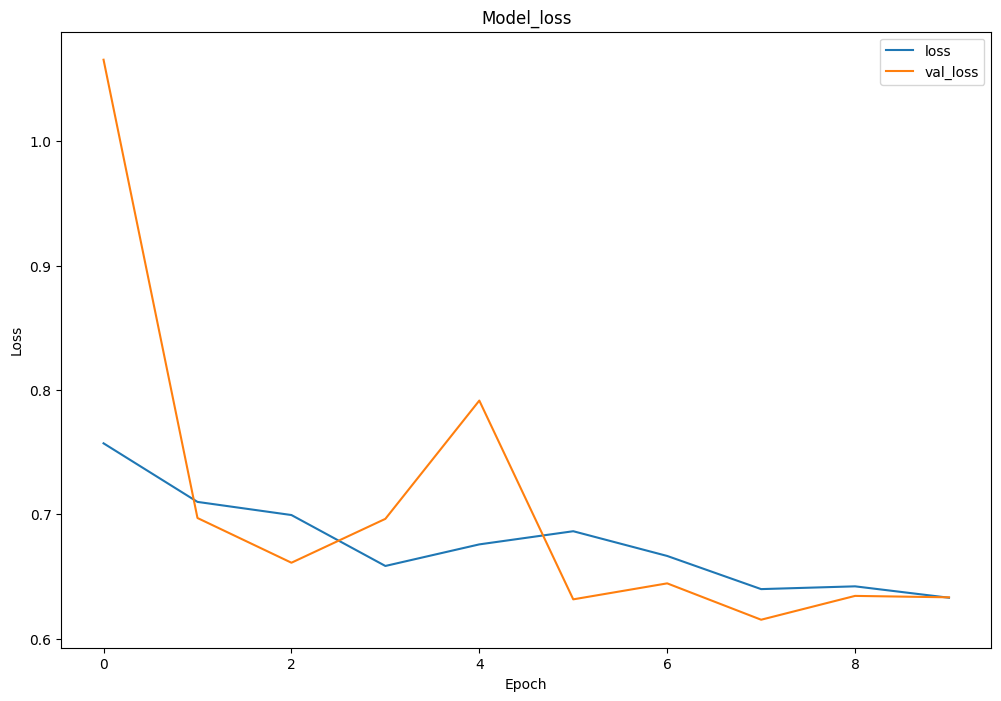

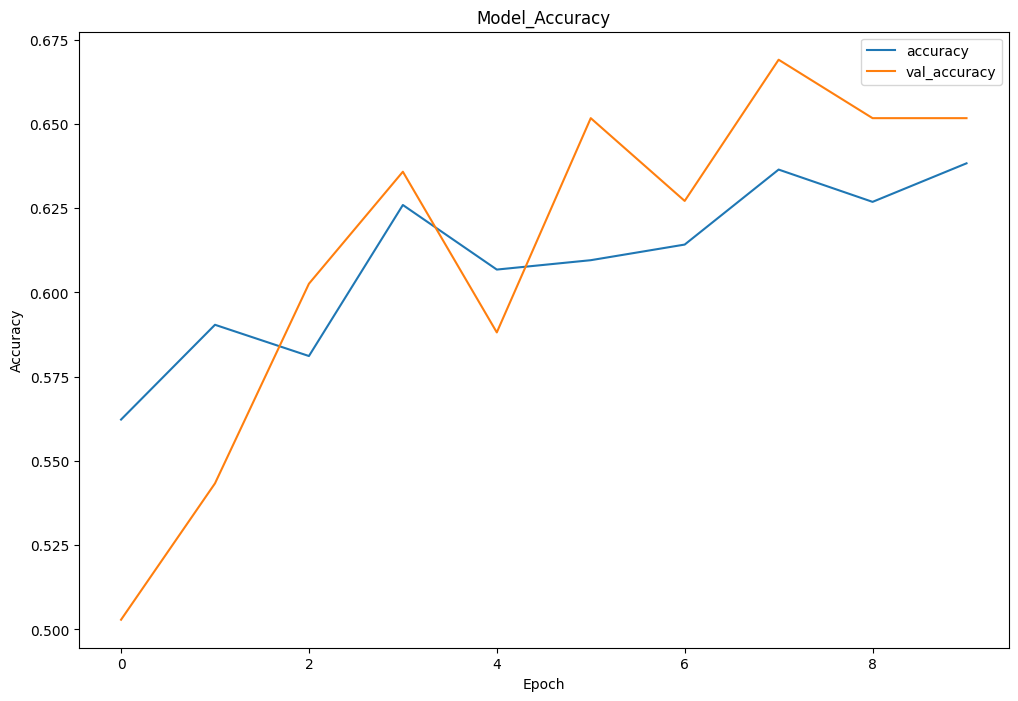

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Treniranje modela sa learning_rate = 0,001 i batch size 64

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping],
    batch_size=64
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - AUC: 0.6912 - accuracy: 0.6390 - loss: 0.6424 - val_AUC: 0.7089 - val_accuracy: 0.6604 - val_loss: 0.6846
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - AUC: 0.6889 - accuracy: 0.6443 - loss: 0.6451 - val_AUC: 0.7218 - val_accuracy: 0.6344 - val_loss: 0.6988
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - AUC: 0.7002 - accuracy: 0.6460 - loss: 0.6319 - val_AUC: 0.7362 - val_accuracy: 0.6691 - val_loss: 0.6159
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - AUC: 0.6887 - accuracy: 0.6382 - loss: 0.6399 - val_AUC: 0.7299 - val_accuracy: 0.6561 - val_loss: 0.6267
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - AUC: 0.7172 - accuracy: 0.6540 - loss: 0.6198 - val_AUC: 0.7284 - val_accuracy: 0.6575 - val_loss: 0.6903
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - AUC: 0.7085 - accuracy: 0.6652 - loss: 0.6293 - val_AUC: 0.7294 - val_accuracy: 0.6792 - val_loss: 0.6223
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

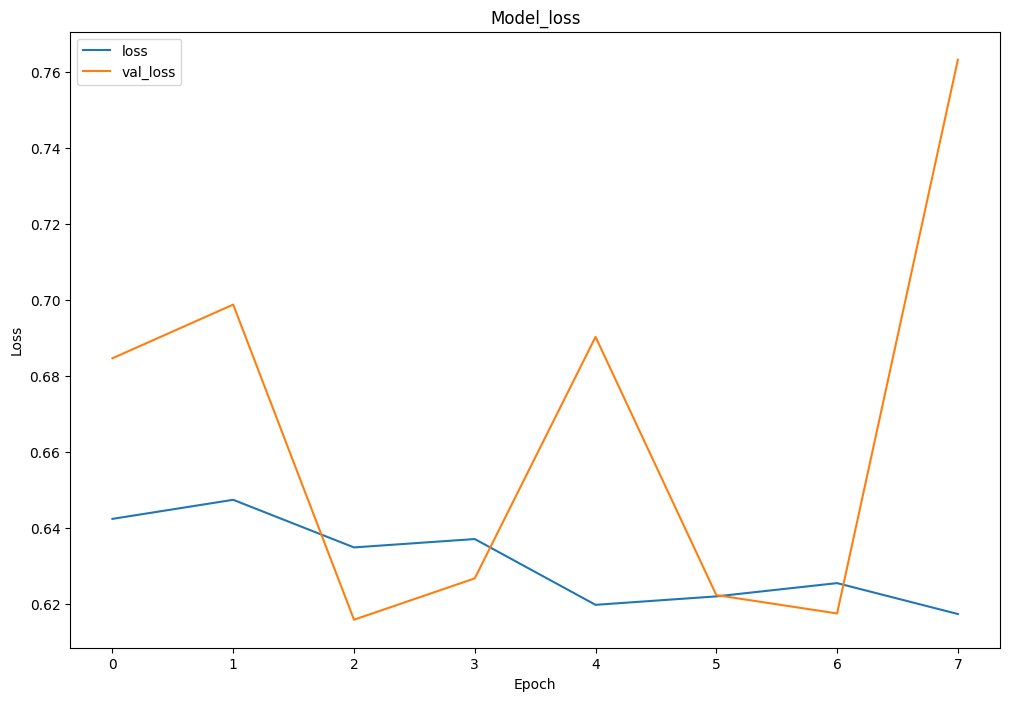

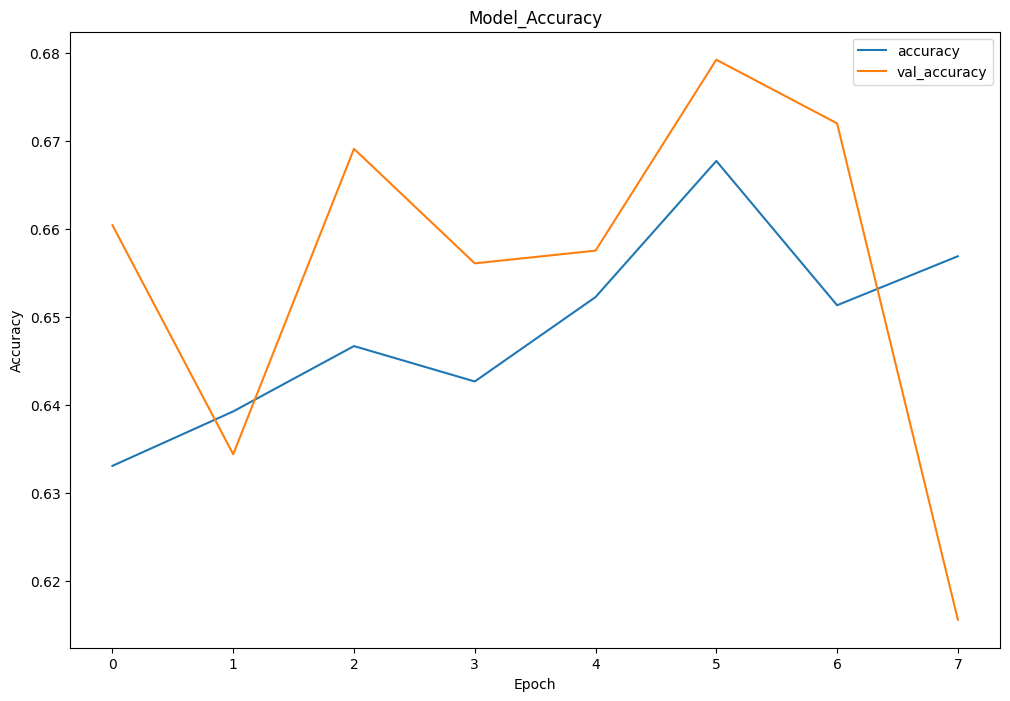

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Promena parametara nije dovela do poboljasanja rezlitata pa sam u model ubacio fine_tuning za poboljsanjerezulata.  Fine tyning odrzujemo poslednjih 20 slojeva i radlimo  treniranje sa ovim parametrima learning_rate = 0,001 i batch size 32

In [ ]:
def CatsVsDogs(image_shape=(224, 224), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model.trainable = False  # Prvo zamrznite sve slojeve baznog modela

    # Odmrzavanje zadnjih 20 slojeva
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = ReLU()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=CatsVsDogs()

In [ ]:
len(model.layers)

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137,025 (11.97 MB)

 Trainable params: 2,084,481 (7.95 MB)

 Non-trainable params: 1,052,544 (4.02 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - AUC: 0.5493 - accuracy: 0.5468 - loss: 0.7279 - val_AUC: 0.6896 - val_accuracy: 0.5361 - val_loss: 0.6959
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - AUC: 0.6573 - accuracy: 0.6086 - loss: 0.6676 - val_AUC: 0.6833 - val_accuracy: 0.5231 - val_loss: 2.0172
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - AUC: 0.6618 - accuracy: 0.6223 - loss: 0.6591 - val_AUC: 0.7229 - val_accuracy: 0.5925 - val_loss: 0.8076
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - AUC: 0.6927 - accuracy: 0.6507 - loss: 0.6454 - val_AUC: 0.7540 - val_accuracy: 0.6561 - val_loss: 0.6975
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - AUC: 0.7165 - accuracy: 0.6619 - loss: 0.6245 - val_AUC: 0.7469 - val_accuracy: 0.6156 - val_loss: 1.1181
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - AUC: 0.7070 - accuracy: 0.6592 - loss: 0.6326 - val_AUC: 0.7588 - val_accuracy: 0.6749 - val_loss: 0.8203


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

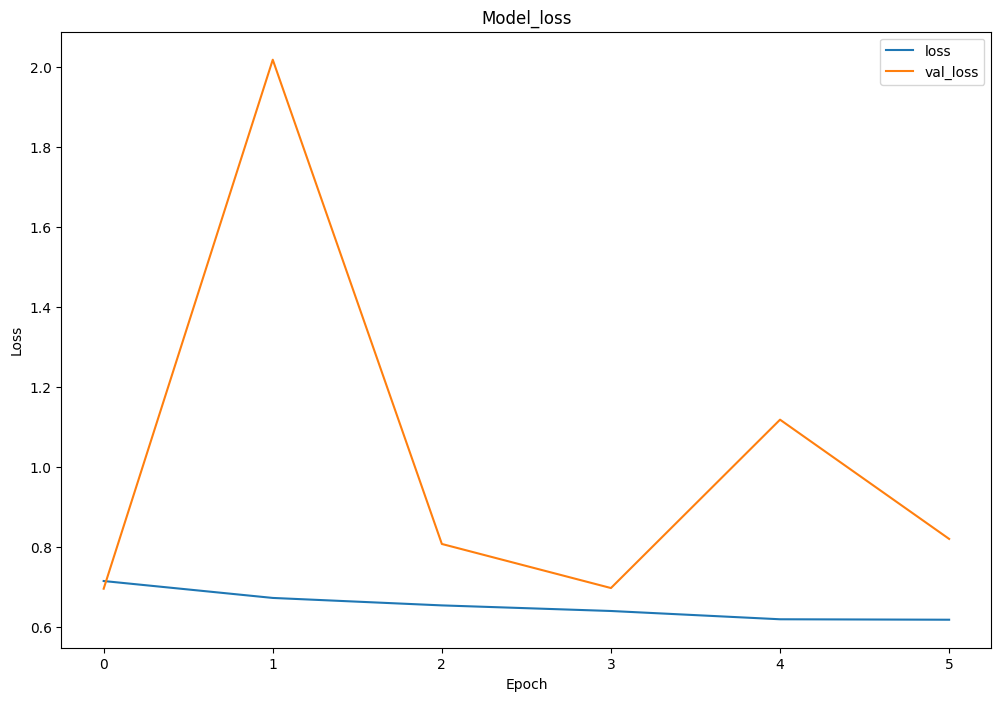

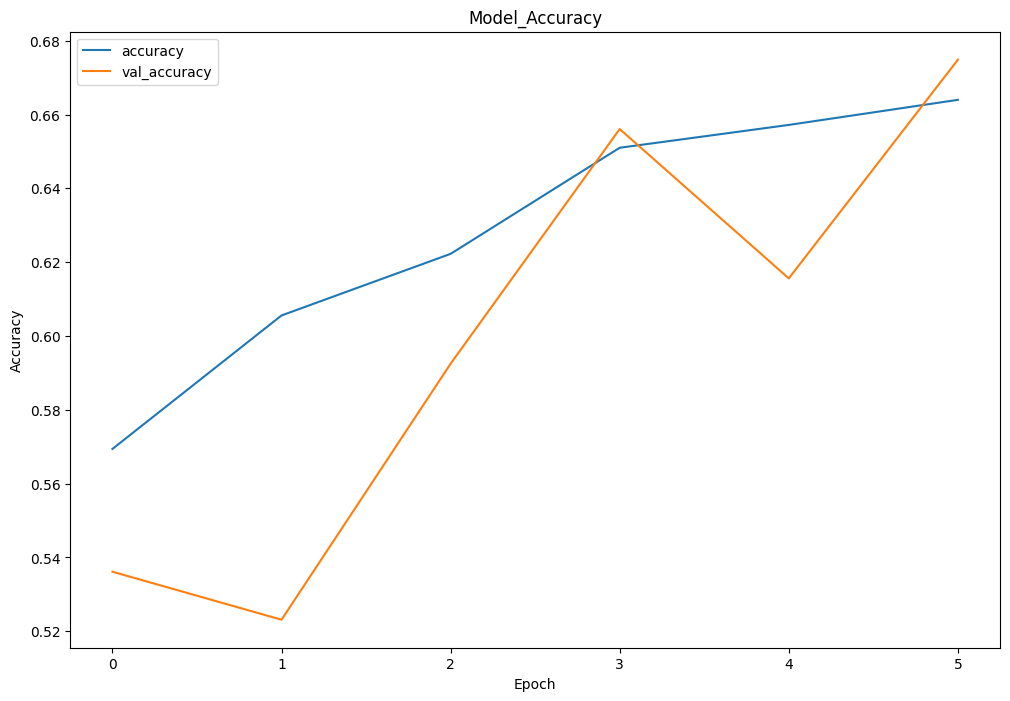

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Model nije doneo nesto bolju preciznost jos je imao nagli skok val_loss druge epohe ,preciznost modela je 68%

Treniranje modela sa learning_rate = 0,001 i batch size 32 sa mapiranjem  bez fine_tuninga ali dodali smo da se podaci noralizuju i smanjili smo rate na 0.25

In [ ]:
def CatsVsDogs(image_shape=(224,224), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top = False, weights = "imagenet") # Promenjeno na ImageNet težine
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=CatsVsDogs()

In [ ]:
normalization_layer = Rescaling(1./255)

# Dodavanje normalizacije u data pipeline
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - AUC: 0.8685 - accuracy: 0.7865 - loss: 0.4528 - val_AUC: 0.9941 - val_accuracy: 0.9754 - val_loss: 0.0860
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - AUC: 0.9328 - accuracy: 0.8540 - loss: 0.3352 - val_AUC: 0.9941 - val_accuracy: 0.9783 - val_loss: 0.0801
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - AUC: 0.9447 - accuracy: 0.8620 - loss: 0.2985 - val_AUC: 0.9943 - val_accuracy: 0.9855 - val_loss: 0.0671
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - AUC: 0.9512 - accuracy: 0.8701 - loss: 0.2841 - val_AUC: 0.9939 - val_accuracy: 0.9841 - val_loss: 0.0784
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - AUC: 0.9514 - accuracy: 0.8760 - loss: 0.2822 - val_AUC: 0.9942 - val_accuracy: 0.9841 - val_loss: 0.0825
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - AUC: 0.9538 - accuracy: 0.8751 - loss: 0.2767 - val_AUC: 0.9940 - val_accuracy: 0.9740 - val_loss: 0.0813
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

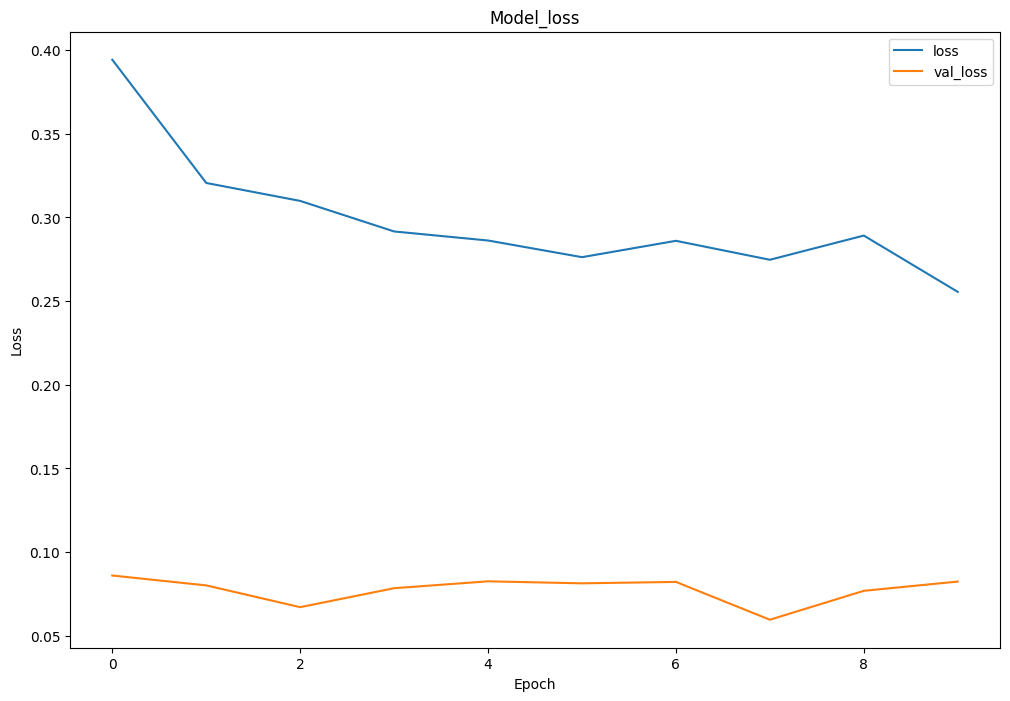

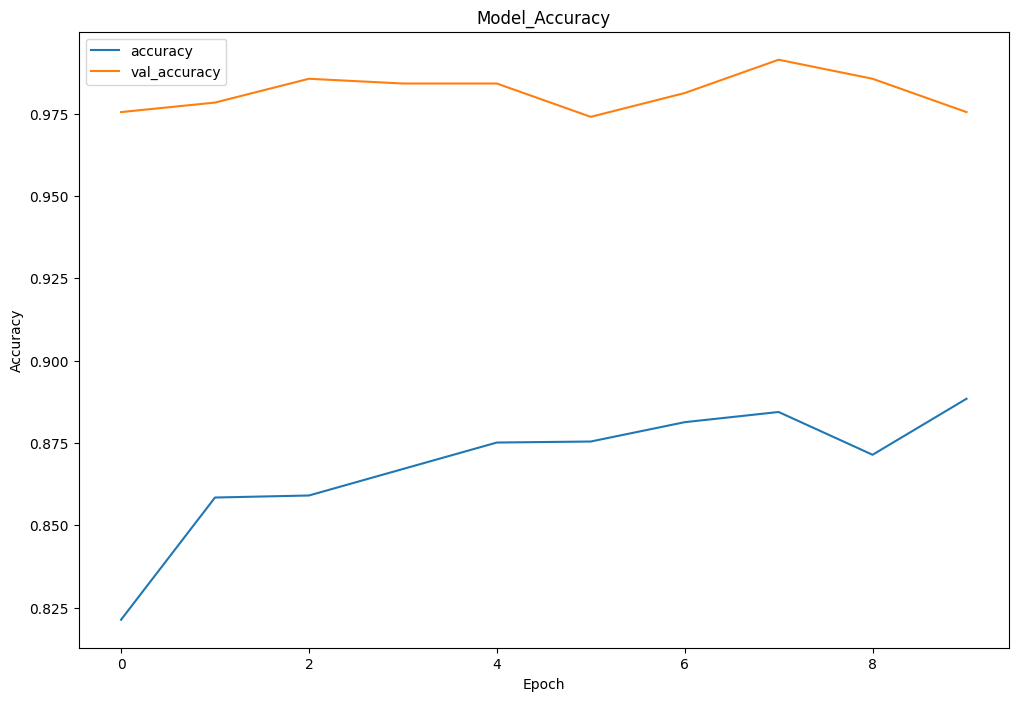

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Dobili smo mnogo bolje parametre nakon normalizcije ali postoji velike razlike izdeju accuracy i val_accuracy , loss-a i val_loss-a povecacemo rase na 0.5 i da radimo fine_tuning

In [ ]:
model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - AUC: 0.9881 - accuracy: 0.9733 - loss: 0.1012


[0.0671527311205864, 0.9783236980438232, 0.9939701557159424]

Ne dobija se preterana neka razlika pa cemo da uvedemo fine_tuning  odmrzavamo posednjih 10 slojeva learning_rate=0.001 i batch_size=32

In [ ]:
def CatsVsDogs(image_shape=(224,224), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top = False, weights = "imagenet") # Promenjeno na ImageNet težine
    base_model.trainable = False
    for layer in base_model.layers[-10:]:
      layer.trainable = True

    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=CatsVsDogs()

In [ ]:
normalization_layer = Rescaling(1./255)

# Dodavanje normalizacije u data pipeline
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - AUC: 0.8527 - accuracy: 0.7781 - loss: 0.4846 - val_AUC: 0.9533 - val_accuracy: 0.9277 - val_loss: 0.5802
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - AUC: 0.9214 - accuracy: 0.8402 - loss: 0.3664 - val_AUC: 0.9882 - val_accuracy: 0.9855 - val_loss: 0.2461
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - AUC: 0.9358 - accuracy: 0.8543 - loss: 0.3301 - val_AUC: 0.9878 - val_accuracy: 0.9740 - val_loss: 0.2475
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - AUC: 0.9380 - accuracy: 0.8463 - loss: 0.3220 - val_AUC: 0.9919 - val_accuracy: 0.9754 - val_loss: 0.1577
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - AUC: 0.9391 - accuracy: 0.8640 - loss: 0.3184 - val_AUC: 0.9950 - val_accuracy: 0.9812 - val_loss: 0.1162
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - AUC: 0.9417 - accuracy: 0.8644 - loss: 0.3122 - val_AUC: 0.9943 - val_accuracy: 0.9769 - val_loss: 0.0972
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

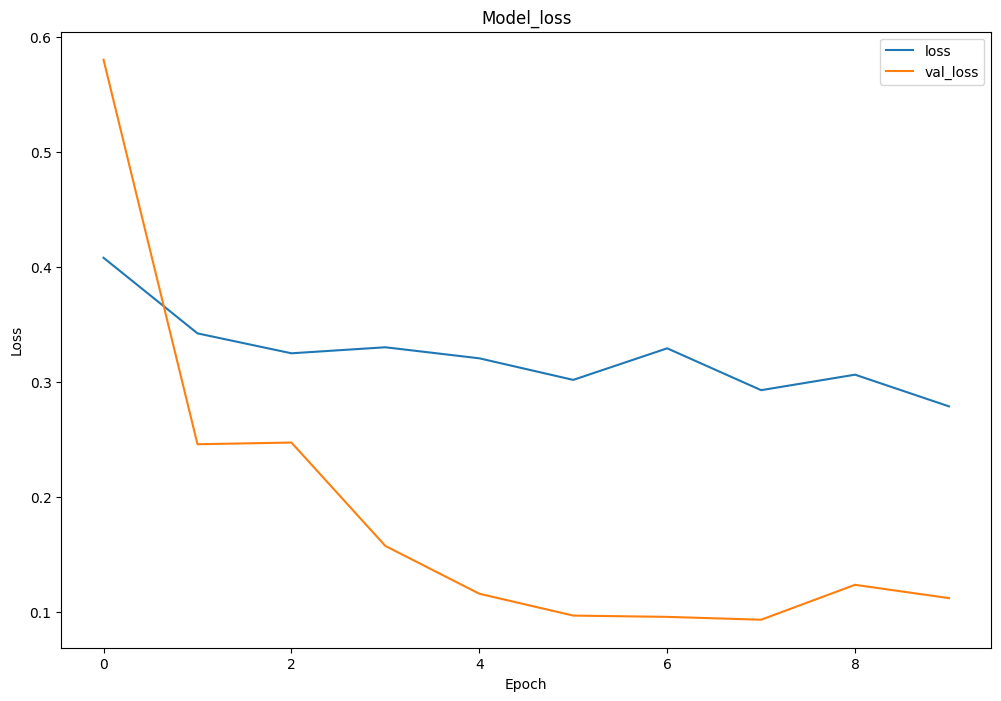

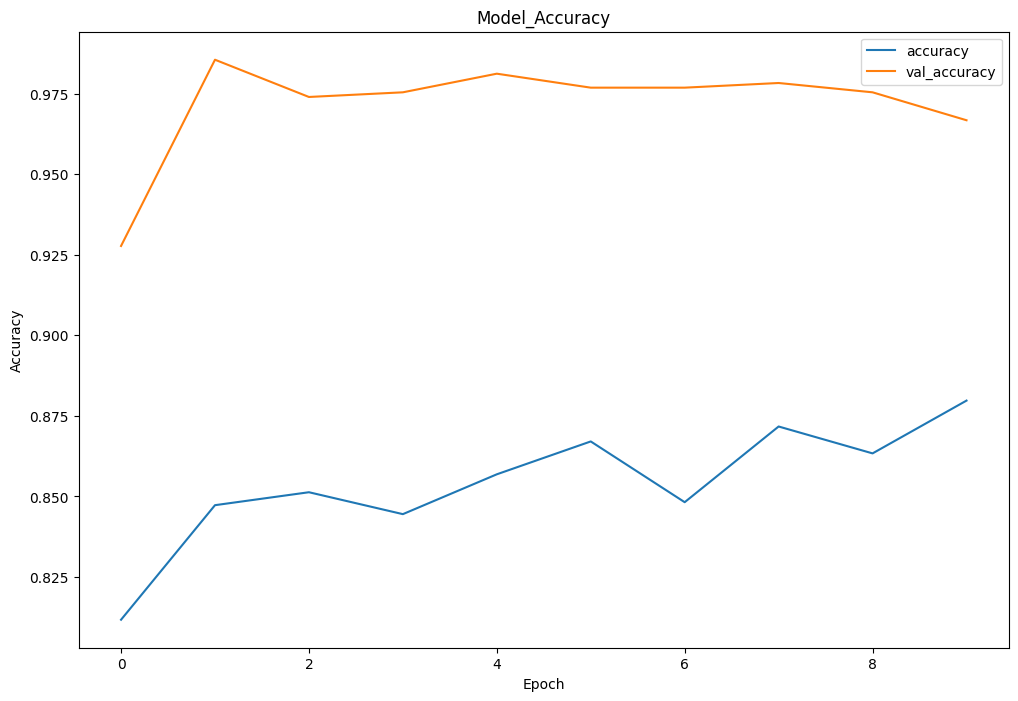

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")



Ovaj model je malo bolji manja je razlika u loss-u i val loss-u ali za accruracy i val_accuracy i dalje ima razlike

U modelu povecali smo broj neurona u Danse leyeru da korsiti vise parametara learning_rate=0.001 i batch_size=32

In [ ]:
def CatsVsDogs(image_shape=(224,224), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top = False, weights = "imagenet") # Promenjeno na ImageNet težine
    base_model.trainable = False
    for layer in base_model.layers[-10:]: # Podesite broj slojeva po potrebi
      layer.trainable = True

    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=CatsVsDogs()

normalization_layer = Rescaling(1./255)

# Dodavanje normalizacije u data pipeline
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
history3 = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]


)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - AUC: 0.9171 - accuracy: 0.8250 - loss: 0.3633 - val_AUC: 0.9087 - val_accuracy: 0.8295 - val_loss: 1.3803
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - AUC: 0.9388 - accuracy: 0.8572 - loss: 0.3180 - val_AUC: 0.9875 - val_accuracy: 0.9740 - val_loss: 0.2497
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - AUC: 0.9344 - accuracy: 0.8535 - loss: 0.3242 - val_AUC: 0.9901 - val_accuracy: 0.9725 - val_loss: 0.2498
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - AUC: 0.9396 - accuracy: 0.8627 - loss: 0.3136 - val_AUC: 0.9905 - val_accuracy: 0.9725 - val_loss: 0.2455
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - AUC: 0.9382 - accuracy: 0.8638 - loss: 0.3162 - val_AUC: 0.9922 - val_accuracy: 0.9827 - val_loss: 0.1882
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - AUC: 0.9523 - accuracy: 0.8706 - loss: 0.2806 - val_AUC: 0.9935 - val_accuracy: 0.9798 - val_loss: 0.1268
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

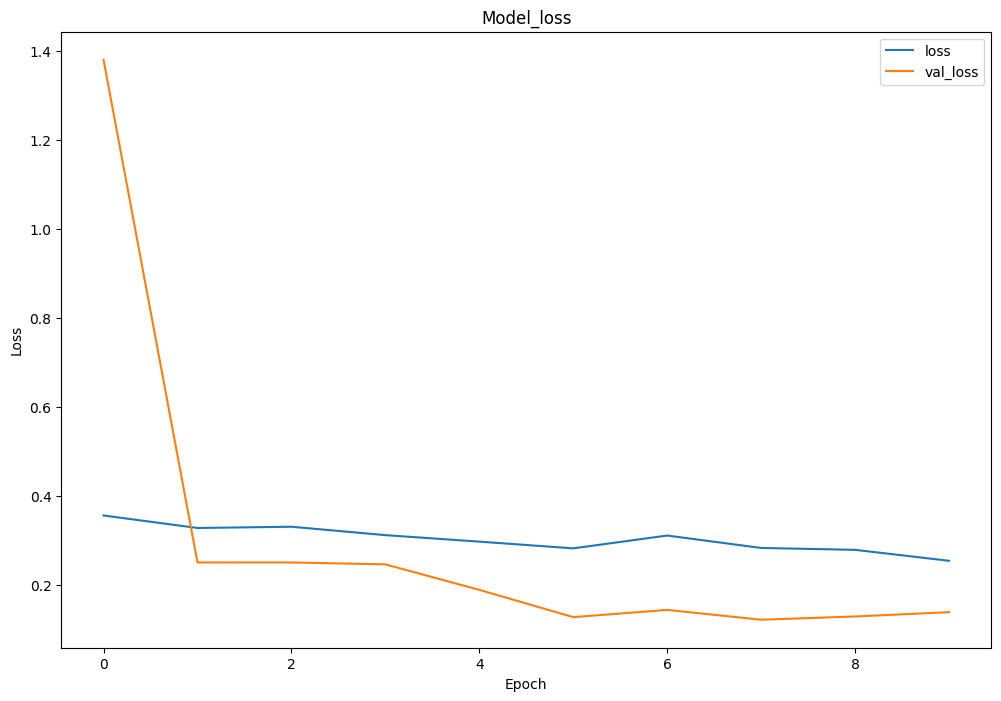

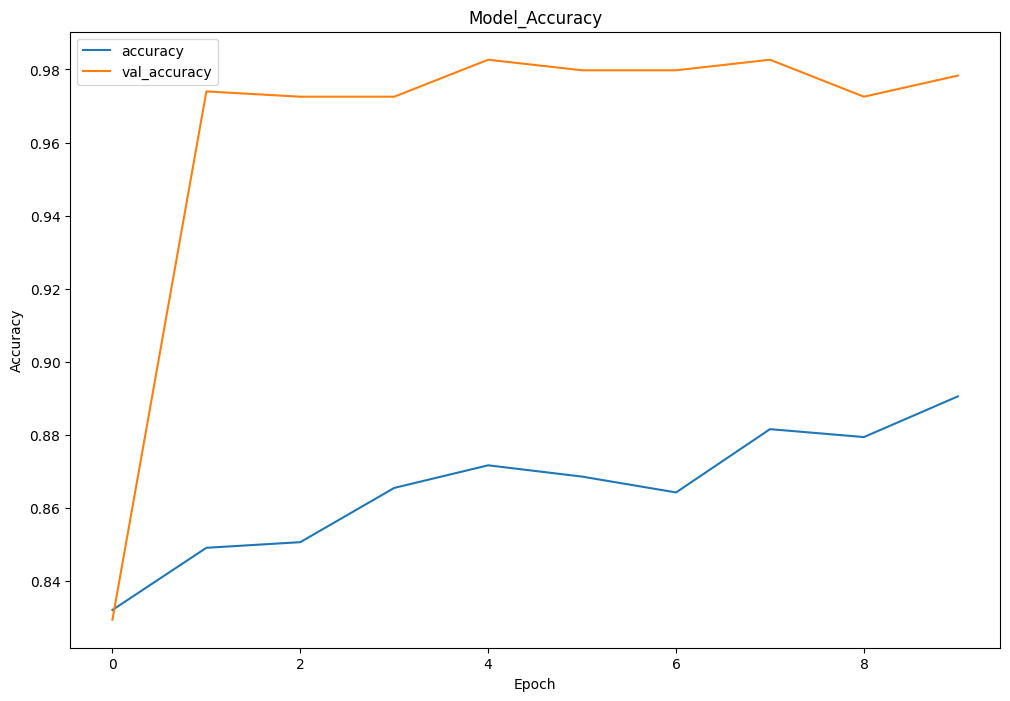

In [ ]:
df_loss_acc = pd.DataFrame(history3.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")



Ovaj model do sad dao najbolje rezultate iako je val_loss bio visok kako su prolazile epohe brzo je spao i bio blizu loss- u
a za val_accyracy vidi se blagi skok posle druge epohe gde i raste accuracy ovo je ok i ako postoji posledica da mozda moze doci do overfittinga

22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


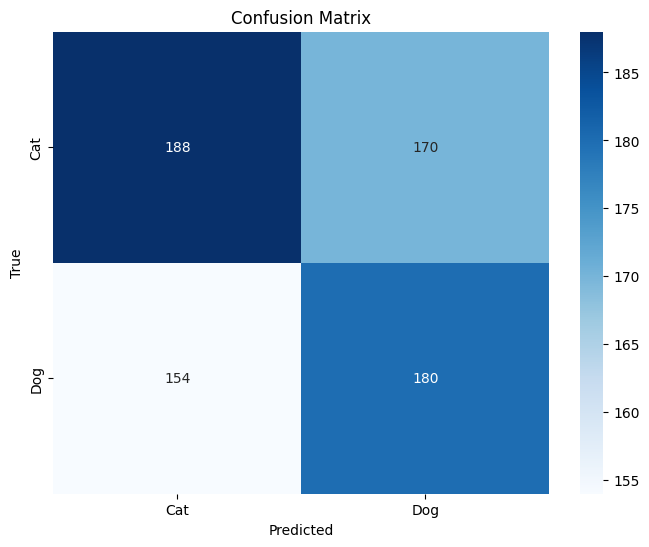

              precision    recall  f1-score   support

         Cat       0.55      0.53      0.54       358
         Dog       0.51      0.54      0.53       334

    accuracy                           0.53       692
   macro avg       0.53      0.53      0.53       692
weighted avg       0.53      0.53      0.53       692



In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)


y_true = np.concatenate([y for x, y in test_dataset], axis=0)


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))